In [ ]:
from datetime import datetime, timedelta
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error

# Ignore warnings
filterwarnings('ignore')

# Set seed
SEED = 123
np.random.seed(SEED)

In [ ]:
df_booking = pd.read_csv('google_flights_airfare_data.csv')

In [ ]:
df_booking.head()

,transaction_id,flight_id,airline,origin,destination,booking_dt,departure_dt,price,fare_class
0,898b2db0d,ced9a2,American Airlines,ORD,BOS,2024-04-02 14:00:10,2024-07-09 07:47:00,327.15,Economy
1,5b8144206,ced9a2,American Airlines,ORD,BOS,2024-05-19 08:44:17,2024-07-09 07:47:00,191.25,Economy
2,2e458f769,ced9a2,American Airlines,ORD,BOS,2024-02-23 22:11:51,2024-07-09 07:47:00,579.79,Economy
3,2c9e3e129,ced9a2,American Airlines,ORD,BOS,2024-04-22 23:43:37,2024-07-09 07:47:00,579.06,Economy
4,9de7ad563,ced9a2,American Airlines,ORD,BOS,2024-04-28 17:55:53,2024-07-09 07:47:00,207.06,Economy


# **EDA**

In [ ]:
df_eda = df_booking.copy()
df_eda['booking_dt'] = pd.to_datetime(df_eda['booking_dt'])
df_eda['departure_dt'] = pd.to_datetime(df_eda['departure_dt'])

df_eda['delta'] = (df_eda['booking_dt']-df_eda['departure_dt']).dt.days
df_eda.head()

df_eda.describe()

,booking_dt,departure_dt,price,delta
count,225209,225209,225209.000000,225209.000000
mean,2023-04-03 08:01:28.147392,2023-07-02 23:32:57.766874112,509.673779,-91.146757
min,2021-10-12 11:58:26,2022-04-09 04:12:00,16.610000,-180.000000
25%,2022-10-02 01:24:33,2023-01-03 18:56:00,245.290000,-136.000000
50%,2023-04-03 14:12:02,2023-06-29 06:27:00,417.280000,-91.000000
75%,2023-10-03 17:29:47,2024-01-02 13:18:00,654.300000,-46.000000
max,2024-09-12 14:58:34,2024-09-15 06:11:00,6639.680000,-2.000000
std,NaN,NaN,385.889088,51.656842


In [ ]:
print(f"{df_eda['airline'].unique()}")

['American Airlines' 'Delta Air Lines' 'United Airlines']


<Axes: xlabel='airline'>

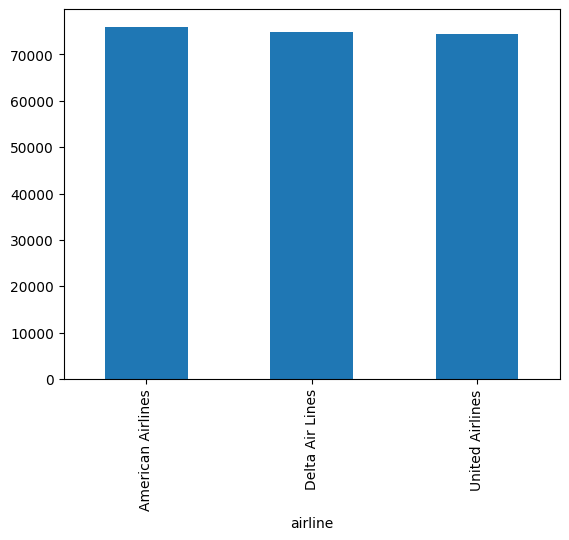

In [ ]:
df_eda.groupby('airline')['transaction_id'].count().plot(kind='bar')

In [ ]:
df_eda['origin'].unique()

array(['ORD', 'SFO', 'ATL', 'JFK', 'LAX'], dtype=object)

In [ ]:
df_eda['destination'].unique()

array(['BOS', 'DFW', 'MIA', 'SEA', 'DEN'], dtype=object)

Text(0, 0.5, 'Transaction Count')

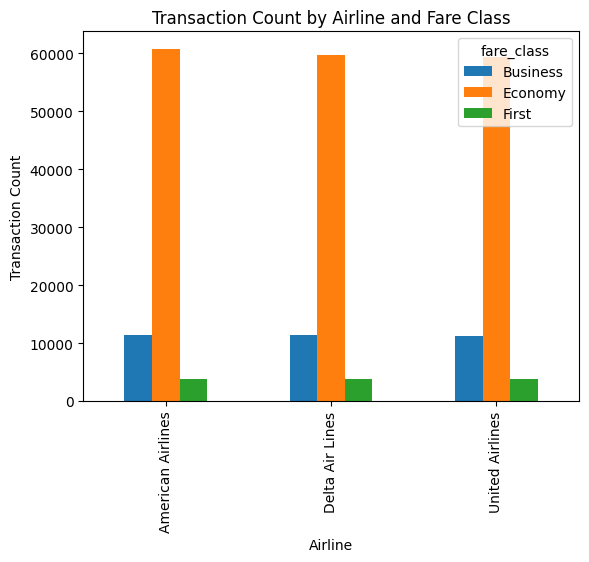

In [ ]:
fare_class = df_eda['fare_class'].unique()
plot_data = df_eda.groupby(['airline','fare_class'])['transaction_id'].count().unstack()
plot_data
plot_data.plot(kind='bar')

plt.title("Transaction Count by Airline and Fare Class")
plt.xlabel("Airline")
plt.ylabel("Transaction Count")

#x-axis title




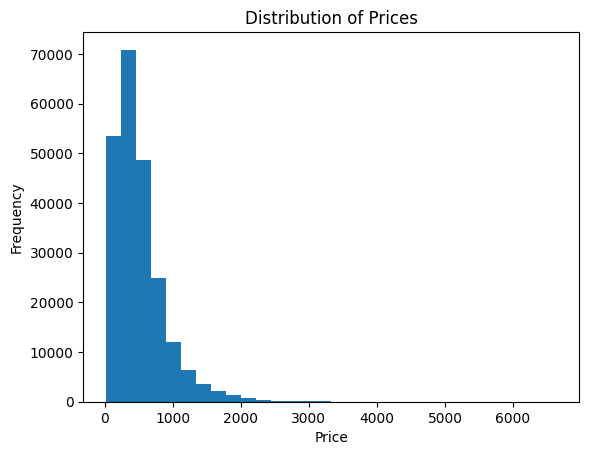

In [ ]:
df_eda['price'].plot(kind='hist',bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()

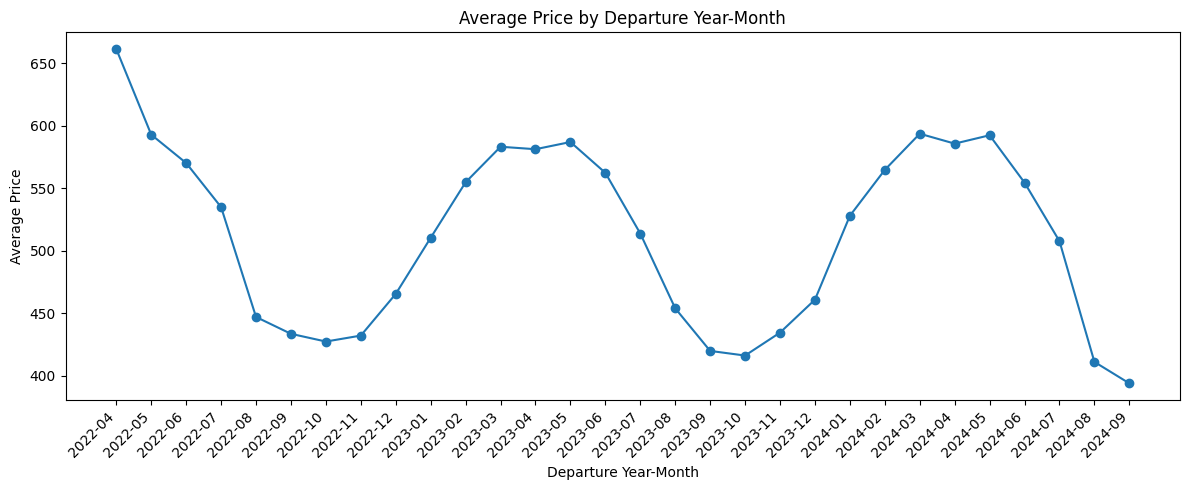

In [ ]:
df_eda['departure_year_month'] = df_eda['departure_dt'].dt.to_period('M')
avg_price_departure = df_eda.groupby('departure_year_month')['price'].mean()
avg_price_departure.index = avg_price_departure.index.astype(str)
avg_price_departure.index
plt.figure(figsize=(12, 5))
plt.plot(avg_price_departure.index, avg_price_departure.values,marker = 'o')
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.xlabel("Departure Year-Month")
plt.ylabel("Average Price")
plt.title("Average Price by Departure Year-Month")
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



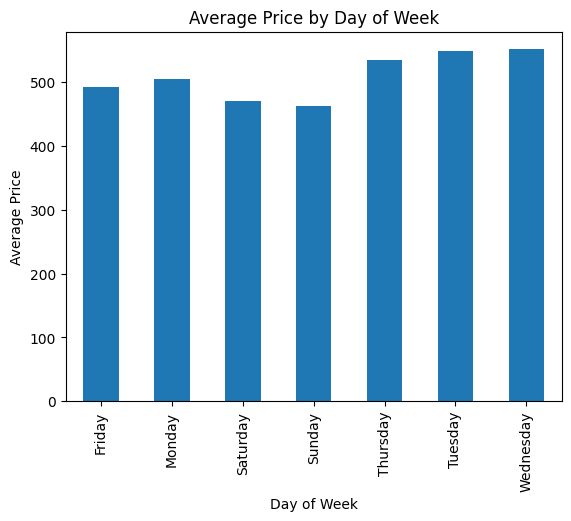

In [ ]:
df_eda['departure_day_of_week'] = df_eda['departure_dt'].dt.day_name()
average_price_perday = df_eda.groupby('departure_day_of_week')['price'].mean()
average_price_perday.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Price')
plt.title('Average Price by Day of Week')
plt.show()

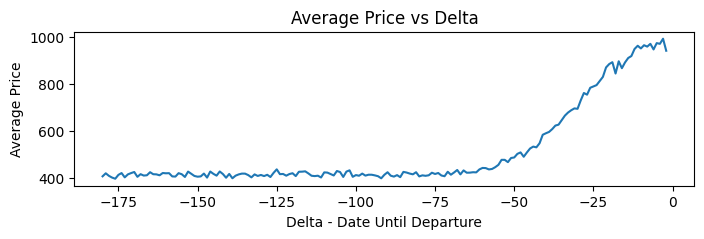

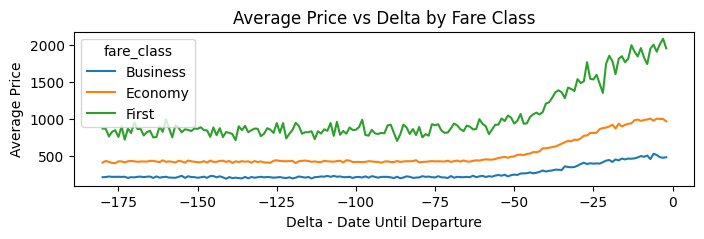

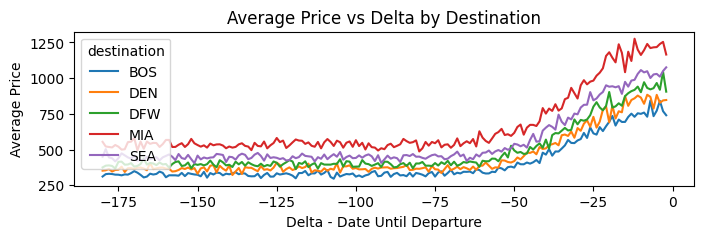

In [ ]:
df_eda.groupby('delta')['price'].mean().plot(figsize=(8,2))
plt.xlabel('Delta - Date Until Departure')
plt.ylabel('Average Price')
plt.title('Average Price vs Delta')
plt.show()


df_eda.groupby(['delta','fare_class'])['price'].mean().unstack().plot(figsize=(8,2))
plt.xlabel('Delta - Date Until Departure')
plt.ylabel('Average Price')
plt.title('Average Price vs Delta by Fare Class')
plt.show()

df_eda.groupby(['delta','destination'])['price'].mean().unstack().plot(figsize=(8,2))
plt.xlabel('Delta - Date Until Departure')
plt.ylabel('Average Price')
plt.title('Average Price vs Delta by Destination')
plt.show()



# Data Preparation


In [ ]:
df_booking['booking_dt'] = pd.to_datetime(df_booking['booking_dt'])
df_booking['departure_dt'] = pd.to_datetime(df_booking['departure_dt'])


# setting fields as category data type
for col in ['airline','origin','destination','fare_class']:
    df_booking[col] = df_booking[col].astype('category')

In [ ]:
def split_time_series(data:pd.DataFrame,time_column:str,train_ratio = 0.7, valid_ratio = 0.20, test_ratio = 0.10):
    """
    Takes the dataFrame, and returns train, validation and test dataframes.
    """

    data = data.sort_values(time_column).reset_index(drop=True)

    # compute split indices
    n = len(data)
    train_end = int(n* train_ratio)
    valid_end = train_end+int(n * valid_ratio)

    #split dataset

    train = data.iloc[:train_end]
    valid = data.iloc[train_end:valid_end]
    test = data.iloc[valid_end:]

    return train, valid, test


df_train, df_valid, df_test = split_time_series(df_booking, time_column = 'departure_dt')

for  _df in  [df_train, df_valid, df_test]:
    print(f'{_df.shape}: Date Range: {_df["departure_dt"].min()} - {_df["departure_dt"].max()}')



(157646, 9): Date Range: 2022-04-09 04:12:00 - 2023-11-27 10:49:00
(45041, 9): Date Range: 2023-11-27 10:49:00 - 2024-04-19 12:30:00
(22522, 9): Date Range: 2024-04-19 12:30:00 - 2024-09-15 06:11:00


In [ ]:
# Split - Price: Y and rest of the columns are regressors

X_train, y_train = df_train.drop(columns=['price']), df_train['price']
X_valid, y_valid = df_valid.drop(columns=['price']), df_valid['price']
X_test, y_test = df_test.drop(columns=['price']), df_test['price']
#X_train

# RF Feature Engineering

In [ ]:
def delta(df:pd.DataFrame,booking_column:str,departure_column:str):
  df['delta'] = (df[booking_column]-df[departure_column]).dt.days
  return df

X_train = delta(X_train,'booking_dt','departure_dt')
X_valid = delta(X_valid,'booking_dt','departure_dt')
X_test = delta(X_test,'booking_dt','departure_dt')


In [ ]:
def decompose_datetime(df: pd.DataFrame, date_column: list):
  for field in date_column:
    df[f'{field}_year'] = df[field].dt.year
    df[f'{field}_month'] = df[field].dt.month
    df[f'{field}_day'] = df[field].dt.day
    df[f'{field}_dayofweek'] = df[field].dt.dayofweek
    df[f'{field}_dayofyear'] = df[field].dt.dayofyear
  return df


X_train = decompose_datetime(X_train,['booking_dt','departure_dt'])
X_valid = decompose_datetime(X_valid,['booking_dt','departure_dt'])
X_test = decompose_datetime(X_test,['booking_dt','departure_dt'])

X_train.head()

,transaction_id,flight_id,airline,origin,destination,booking_dt,departure_dt,fare_class,delta,booking_dt_year,booking_dt_month,booking_dt_day,booking_dt_dayofweek,booking_dt_dayofyear,departure_dt_year,departure_dt_month,departure_dt_day,departure_dt_dayofweek,departure_dt_dayofyear
0,26876b599,107081,United Airlines,ORD,MIA,2022-02-22 20:53:02,2022-04-09 04:12:00,Economy,-46,2022,2,22,1,53,2022,4,9,5,99
1,d60d34b92,107081,United Airlines,ORD,MIA,2022-01-03 05:41:09,2022-04-09 04:12:00,Economy,-96,2022,1,3,0,3,2022,4,9,5,99
2,3d10ab2fc,107081,United Airlines,ORD,MIA,2022-02-23 11:46:59,2022-04-09 04:12:00,Economy,-45,2022,2,23,2,54,2022,4,9,5,99
3,dc5c482b0,107081,United Airlines,ORD,MIA,2021-10-21 19:18:40,2022-04-09 04:12:00,Economy,-170,2021,10,21,3,294,2022,4,9,5,99
4,38c1225c8,107081,United Airlines,ORD,MIA,2022-01-09 09:33:45,2022-04-09 04:12:00,Business,-90,2022,1,9,6,9,2022,4,9,5,99


# Feature Selection

In [ ]:
candidate_features = ['airline',
                       'origin',
                       'destination',
                       'fare_class',
                       'delta',
                       'booking_dt_year',
                       'booking_dt_month',
                       'booking_dt_day',
                       'booking_dt_dayofweek',
                       'booking_dt_dayofyear',
                       'departure_dt_year',
                       'departure_dt_month',
                       'departure_dt_day',
                       'departure_dt_dayofweek',
                       'departure_dt_dayofyear']


# Copy of X_train to avoid modifying the orginal df
X_train_encoded = X_train[candidate_features].copy()

encoder = LabelEncoder()
for col in ['airline', 'origin', 'destination', 'fare_class']:
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col])


# Initialize SelectKBest with f_regression as the scoring function

selector = SelectKBest(f_regression, k=10) # Select top 10 features

# Fit the SelectKbest to the encoded training data - this gives us the best
selector = selector.fit(X_train_encoded, y_train)

selected_features = X_train_encoded.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)





Selected Features: ['airline', 'destination', 'fare_class', 'delta', 'booking_dt_year', 'booking_dt_dayofweek', 'departure_dt_year', 'departure_dt_month', 'departure_dt_dayofweek', 'departure_dt_dayofyear']


Feature Importance


In [ ]:
# Get feature scores and p-values
feature_scores = selector.scores_
feature_scores

p_values = selector.pvalues_
p_values

df_feature_ranking = pd.DataFrame({'Feature': X_train_encoded.columns, 'Score': feature_scores, 'p-value': p_values})

df_feature_ranking


,Feature,Score,p-value
0,airline,160.732790,8.157303e-37
1,origin,7.640606,5.707536e-03
2,destination,5325.790506,0.000000e+00
3,fare_class,26353.341708,0.000000e+00
4,delta,20919.758532,0.000000e+00
5,booking_dt_year,926.271029,7.426504e-203
6,booking_dt_month,1.867544,1.717586e-01
7,booking_dt_day,0.524888,4.687652e-01
8,booking_dt_dayofweek,838.442620,7.207619e-184
9,booking_dt_dayofyear,2.475444,1.156388e-01


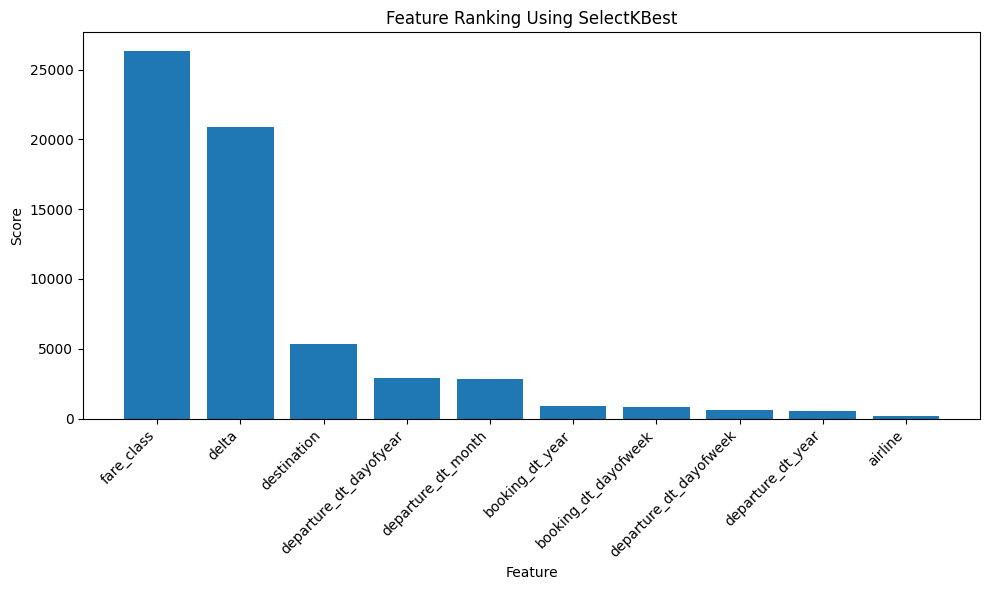

In [ ]:
# Filtering the feature ranking to include only selected features
df_selected_ranking = df_feature_ranking[df_feature_ranking['Feature'].isin(selected_features)].sort_values('Score', ascending=False).reset_index(drop=True)


plt.figure(figsize=(10, 6))
plt.bar(df_selected_ranking['Feature'], df_selected_ranking['Score'])
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Feature Ranking Using SelectKBest')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
X_test = X_test[selected_features]

X_train

,airline,destination,fare_class,delta,booking_dt_year,booking_dt_dayofweek,departure_dt_year,departure_dt_month,departure_dt_dayofweek,departure_dt_dayofyear
0,United Airlines,MIA,Economy,-46,2022,1,2022,4,5,99
1,United Airlines,MIA,Economy,-96,2022,0,2022,4,5,99
2,United Airlines,MIA,Economy,-45,2022,2,2022,4,5,99
3,United Airlines,MIA,Economy,-170,2021,3,2022,4,5,99
4,United Airlines,MIA,Business,-90,2022,6,2022,4,5,99
...,...,...,...,...,...,...,...,...,...,...
157641,Delta Air Lines,BOS,Business,-29,2023,6,2023,11,0,331
157642,Delta Air Lines,BOS,Economy,-163,2023,6,2023,11,0,331
157643,Delta Air Lines,BOS,Business,-125,2023,2,2023,11,0,331
157644,Delta Air Lines,BOS,Economy,-130,2023,4,2023,11,0,331


In [ ]:
!pip install xgboost==1.7.5 scikit-learn==0.24.2

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


# Model Selection

In [ ]:
# Parameters for the XGBoost model
baseline_model = xgb.XGBRegressor(objective='reg:squarederror',
                                  n_estimators=200,
                                  learning_rate=0.1,
                                  max_depth=10,  # Corrected parameter name
                                  random_state=SEED,
                                  enable_categorical = True)


baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_train = baseline_model.predict(X_train)
y_pred_valid = baseline_model.predict(X_valid)
y_pred_test = baseline_model.predict(X_test)

#Evaluation:
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_valid = mean_absolute_percentage_error(y_valid, y_pred_valid)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

for name,mape in zip(['train','valid','test'],[mape_train,mape_valid,mape_test]):
  print(f'{name} MAPE: {mape*100:.2f}%')


train MAPE: 48.99%
valid MAPE: 61.06%
test MAPE: 60.70%


In [ ]:
# Parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [30, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10],
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    enable_categorical=True
)

# Number of random combinations to try
n_iter = 30

# Generate random combinations of parameters
param_list = list(ParameterSampler(param_distributions=param_dist, n_iter=n_iter, random_state=SEED))

# Initialize result storage
best_params = None
best_score = float('inf')

# Train and evaluate models for each parameter combination
for i, params in enumerate(param_list):
    print(f"[{i + 1}/{n_iter}] Testing parameters: {params}")

    # Initialize the XGBoost model with current parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=SEED,
        enable_categorical=True,
        **params
    )

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    # Predict on validation data
    y_pred = model.predict(X_valid)

    # Calculate validation score
    mape = mean_absolute_percentage_error(y_valid, y_pred)

    # Update best parameters and score if current score is better
    if mape < best_score:
        best_score = mape
        best_params = params

print(f"Best parameters found: {best_params}")
print(f"Best validation MAPE: {best_score:.3f}")




[1/30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
[2/30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
[3/30] Testing parameters: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 10, 'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
[4/30] Testing parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 1.0}
[5/30] Testing parameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.8}
[6/30] Testing parameters: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0.01, 'n_estimators': 

In [ ]:
# Using the parameter, which gave the best result on Validation Set

best_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                              random_state=SEED,
                              enable_categorical = True,
                              **best_params)

# Train the model on the entire training et
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = best_model.predict(X_train)
y_pred_valid = best_model.predict(X_valid)
y_pred_test = best_model.predict(X_test)


#Evaluation
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_valid = mean_absolute_percentage_error(y_valid, y_pred_valid)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

for name,mape in zip(['train','valid','test'],[mape_train,mape_valid,mape_test]):
  print(f'{name} MAPE: {mape*100:.2f}%')


train MAPE: 48.99%
valid MAPE: 59.38%
test MAPE: 60.72%


Evaluation


In [ ]:
df_eval =  df_test.copy()

df_eval = df_eval.assign(Model = y_pred_test)

df_eval = delta(df_eval,'departure_dt','booking_dt')


In [ ]:
# Benchmark Prediction
def benchmark_predict(train: pd.DataFrame, test: pd.DataFrame):
    """
    Calculates a benchmark prediction for the target variable ('price')
    based on the average price for each 'delta' value in the training data.

    Args:
        train (pd.DataFrame): The training data containing 'delta' and 'price' columns.
        test (pd.DataFrame): The test data containing the 'delta' column.

    Returns:
        np.ndarray: An array of benchmark predictions for the test data.
    """
    # Make copies
    train = train.copy()
    test = test.copy()

    # Compute delta
    train = delta(train,'booking_dt','departure_dt',)
    test = delta(test, 'booking_dt','departure_dt')

    # Calculate the average price for each 'delta' value in the training data
    train = train.groupby('delta')['price'].mean().rename('benchmark_train_pred')

    # Merge the test data with the average prices calculated from the training data
    return test.merge(train, on='delta', how='left')['benchmark_train_pred'].values


# Generate predictions
y_pred_business = benchmark_predict(df_train, df_test)
df_eval = df_eval.assign(Benchmark=y_pred_business)


In [ ]:
for column in ['Benchmark','Model']:
  # % error
  df_eval['MPE_'+column] = (df_eval[column]-df_eval['price'])/df_eval['price']
  # abs % error
  df_eval['MAPE_'+column] = df_eval['MPE_'+column].abs()
  # Bias
  df_eval['Bias_'+column] = df_eval[column]-df_eval['price']


df_eval.filter(regex='(PE|APE|Bias)',axis = 1).mean().rename("Errors").round(4)



,Errors
MPE_Benchmark,0.4356
MAPE_Benchmark,0.7429
Bias_Benchmark,-41.5490
MPE_Model,0.3646
MAPE_Model,0.6072
Bias_Model,6.3299


In [ ]:
df_eval.filter(regex='(fare_class|MPE|MAPE|BIAS)',axis = 1).groupby('fare_class').mean().loc[['Economy','Business','First']]

,MPE_Benchmark,MAPE_Benchmark,MPE_Model,MAPE_Model
fare_class,,,,
Economy,0.265295,0.587933,0.354168,0.596723
Business,1.634243,1.662032,0.419869,0.663339
First,-0.360001,0.504239,0.367102,0.608179


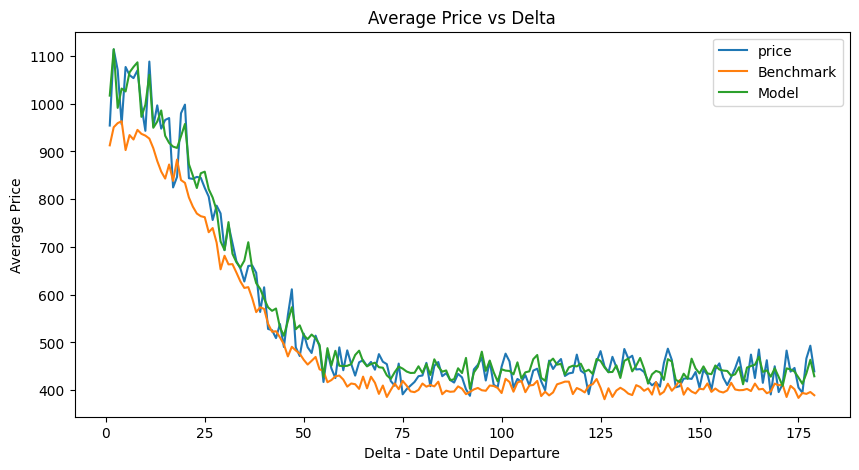

In [ ]:
df_eval.groupby('delta')[['price','Benchmark','Model']].mean().plot(figsize=(10,5))
plt.xlabel('Delta - Date Until Departure')
plt.ylabel('Average Price')
plt.title('Average Price vs Delta')
plt.show()

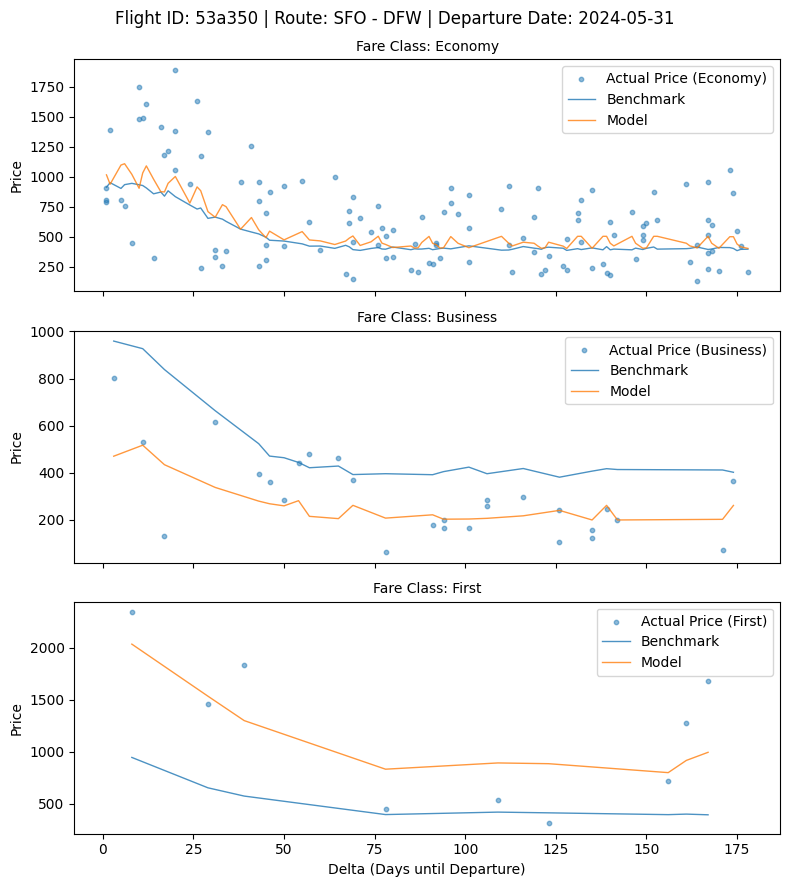

In [ ]:


num_fare_classes = len(df_test['fare_class'].unique())

fig, axes = plt.subplots(nrows=num_fare_classes, ncols=1, figsize=(8, 3 * num_fare_classes), sharex=True)

# Randomly select flight id
sample = df_test.sample(1).to_dict('records')[0]
df_sample = df_eval[df_eval.flight_id == sample['flight_id']]

# Define the desired order of fare classes
fare_class_order = ['Economy', 'Business', 'First']

# Plot for each fare class in the desired order
for i, fare_class in enumerate(fare_class_order):  # Iterate through fare_class_order
    ax = axes[i]  # Get the current subplot axis
    df_subset = df_sample[df_sample.fare_class == fare_class]

    # Scatter plot
    df_subset.plot.scatter(x='delta', y='price', ax=ax, label=f'Actual Price ({fare_class})', s=10, alpha=0.50)

    # Line plot
    df_subset.groupby('delta')[['Benchmark', 'Model']].mean().plot(ax=ax, label=[f'{fare_class} Benchmark', f'{fare_class} Model'], alpha=0.8, linewidth=1)

    ax.set_title(f"Fare Class: {fare_class}", fontsize=10)  # Set subplot title
    ax.set_ylabel('Price')  # Set y-axis label
    ax.legend()  # Show legend

plt.suptitle(f"Flight ID: {sample['flight_id']} | Route: {sample['origin']} - {sample['destination']} | Departure Date: {sample['departure_dt'].date()}")
plt.xlabel('Delta (Days until Departure)')  # Set x-axis label for the entire figure
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()